# Basic usage of `qbiome`

First, load package and some other helper packages for the analysis:

In [1]:
import qbiome
from qbiome.data_formatter import DataFormatter
from qbiome.quantizer import Quantizer
from qbiome.qnet_orchestrator import QnetOrchestrator
from qbiome.forecaster import Forecaster
from qbiome.hypothesis import Hypothesis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
plt.style.use("ggplot")

from qbiome.qutil import qsmooth

Next, we load the data. 

For this example, we use a dataset from Bokulich et. al 

- [Antibiotics, birth mode, and diet shape microbiome maturation during early life](https://doi.org/10.1126/scitranslmed.aad7121) 

In [2]:
dirname = "example_data/"
data = (
    dirname + "SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_TaxaRelativeAbundance.csv"
)
meta = dirname + "SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_Characteristics.csv"
base_tax = "Class"

formatter = DataFormatter()
data = formatter.load_data(
    fpath_data=data, fpath_meta=meta, taxon_name="Class", tax_dict={}
)
quantizer = Quantizer()
qnet_orchestrator = QnetOrchestrator(quantizer)

quantized = quantizer.quantize_df(data)
features, label_matrix = quantizer.get_qnet_inputs(quantized)
dequantized = quantizer.dequantize_to_df(label_matrix)
dequantized_plot = quantizer.melt_into_plot_format(dequantized)
quantizer.fit_random_forest(data, dequantized_plot)

There are 52 unique biomes and 1216 unique samples
There are 311 unique days
There are 99 unique weeks


In [3]:
data

,sample_id,subject_id,variable,week,value
11,MBSMPL0020-6-10,1,Actinobacteria,27,0.366650
12,MBSMPL0020-6-10,1,Bacilli,27,0.013550
13,MBSMPL0020-6-10,1,Bacteroidia,27,0.507248
14,MBSMPL0020-6-10,1,Campylobacteria,27,0.002032
15,MBSMPL0020-6-10,1,Clostridia,27,0.035906
...,...,...,...,...,...
10233,MBSMPL0020-6-998,16,Campylobacteria,7,0.000377
10234,MBSMPL0020-6-998,16,Clostridia,7,0.155196
10235,MBSMPL0020-6-998,16,Coriobacteriia,7,0.001454
10236,MBSMPL0020-6-998,16,Fusobacteriia,7,0.143349


In [4]:
data.week.min(), data.week.max()

(1, 98)

In [5]:
BIOMES = list(data.variable.value_counts().index.values)
BIOMES

['Bacilli',
 'Clostridia',
 'Actinobacteria',
 'Gammaproteobacteria',
 'Bacteroidia',
 'Negativicutes',
 'Coriobacteriia',
 'Verrucomicrobiae',
 'Desulfovibrionia',
 'Fusobacteriia',
 'Alphaproteobacteria',
 'Campylobacteria',
 'unclassified_Bacteria',
 'Vampirivibrionia',
 'Cyanobacteriia',
 'Lentisphaeria']

# Fit the qnet model

In [6]:
qnet_orchestrator.train_qnet(
    features, label_matrix, alpha=0.3, min_samples_split=2, out_fname=None
)
qnet_orchestrator.save_qnet("example_qnet.joblib")

Generate tree files to inspect model structure

In [7]:
outdirname = 'dotfiles'
import os
if not os.path.isdir(outdirname):
    os.makedirs(outdirname)
for f in os.listdir(outdirname):
    os.remove(os.path.join(outdirname, f))    
qnet_orchestrator.export_qnet_tree_dotfiles(outdirname)

! cd 'dotfiles'; for i in `ls *dot`; do dot -Tpng $i -o ${i/dot/png}; done >& /dev/null

-rw-r--r--  1 ncsizemore  staff   383K Feb 29 09:41 dotfiles/Actinobacteria_5.png
-rw-r--r--  1 ncsizemore  staff   362K Feb 29 09:41 dotfiles/Bacteroidia_27.png
-rw-r--r--  1 ncsizemore  staff   350K Feb 29 09:41 dotfiles/Bacilli_1.png
ls: stdout: Undefined error: 0


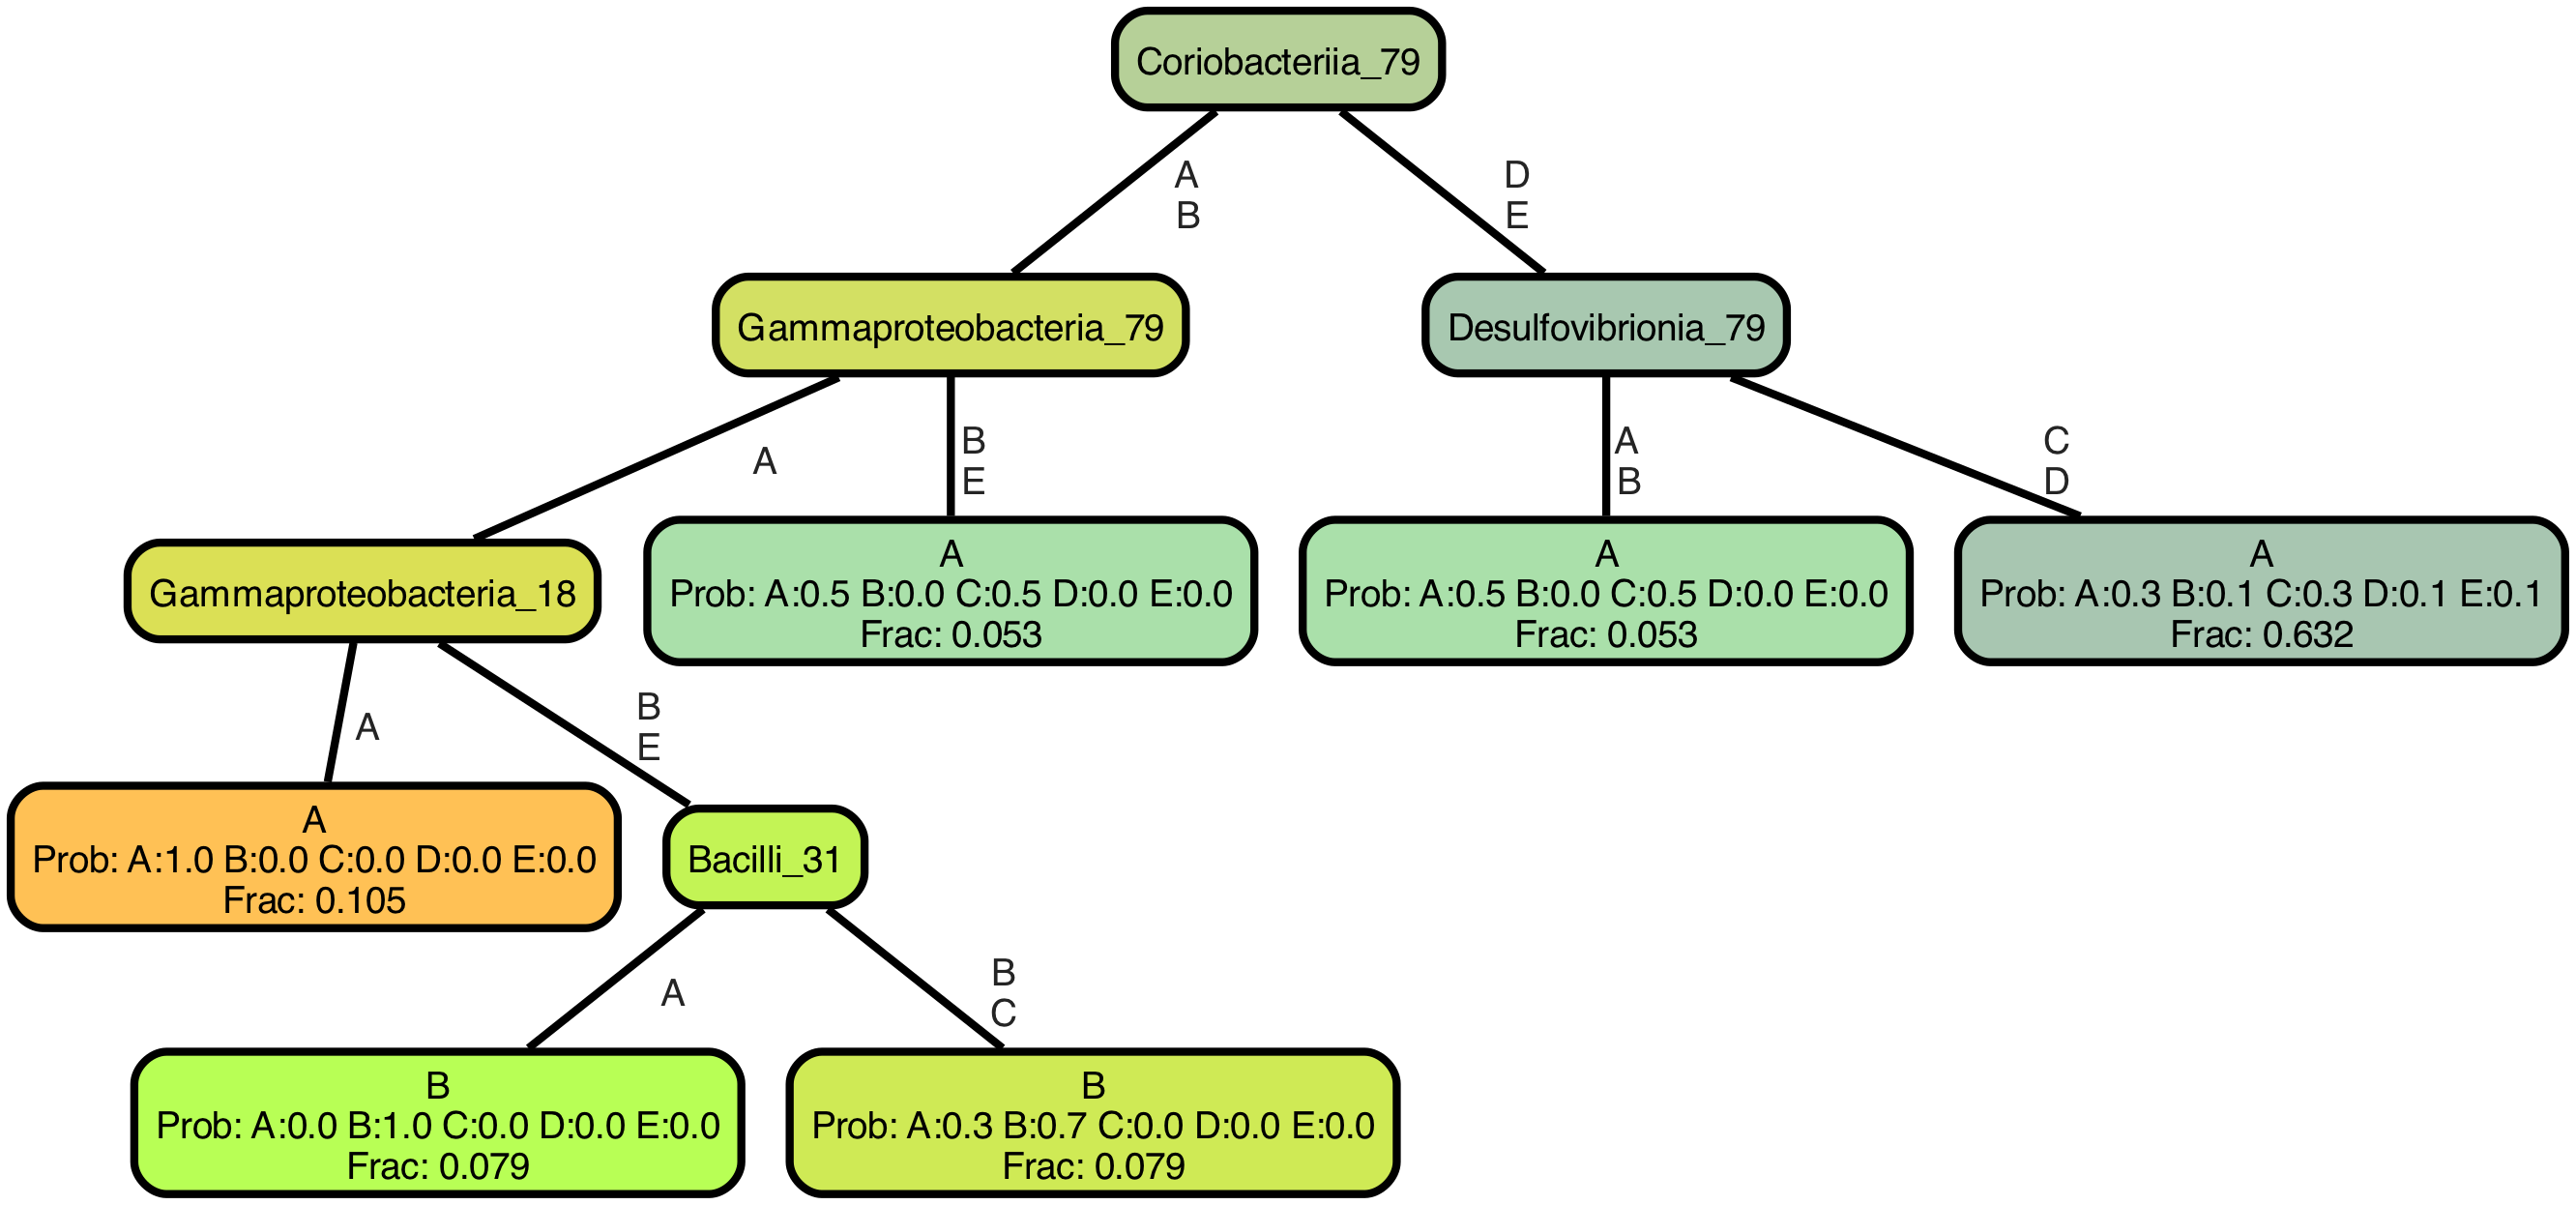

In [8]:
! ls -lhS dotfiles/*png | head -n 3

from IPython.display import Image
from IPython.core.display import HTML 
Image(filename='dotfiles/Gammaproteobacteria_5.png')

# Generate example hypotheses (`LOMAR` coefficients)

In [9]:
hypothesis = Hypothesis(
    quantizer=quantizer, model_path=outdirname, detailed_labels=True
)

hypothesis.causal_constraint = -2
hypothesis.no_self_loops = False

hypothesis.get(time_start=10, time_end=20)
hypothesis.to_dot("hypothesis_10_20.dot")
hypothesis.hypotheses.sort_values("src")

100%|██████████| 16/16 [00:02<00:00,  5.97it/s]


,src,tgt,time_tgt,lomar,pvalue
28,Actinobacteria,Negativicutes,10.0,-0.675423,0.000000e+00
27,Actinobacteria,Negativicutes,18.0,-0.034230,1.699738e-34
55,Actinobacteria,Actinobacteria,10.0,-2.175187,0.000000e+00
35,Actinobacteria,Gammaproteobacteria,18.0,-0.092338,0.000000e+00
36,Actinobacteria,Verrucomicrobiae,18.0,1.005797,0.000000e+00
12,Actinobacteria,Bacteroidia,19.0,0.641450,0.000000e+00
11,Actinobacteria,Bacteroidia,18.0,0.083769,1.195468e-126
54,Actinobacteria,Actinobacteria,18.0,0.039790,0.000000e+00
52,Alphaproteobacteria,Actinobacteria,18.0,-1.043284,0.000000e+00
15,Alphaproteobacteria,Bacilli,14.0,-1.207329,0.000000e+00


# Forecast microbiome evolution

In [10]:
# forecast from time SW
SW = 29
qnet_orchestrator = QnetOrchestrator(quantizer)
qnet_orchestrator.load_qnet("example_qnet.joblib")
forecaster = Forecaster(qnet_orchestrator)
# can specify an end week or default to the max end week in the data
forecasted_ = forecaster.forecast_data(label_matrix, start_week=SW).assign(
    source="forecasted"
)

In [11]:
label_matrix.shape

(44, 898)

In [12]:
# forecasted_dict[0]
DF = forecasted_
SUBJECTS = DF.subject_id.value_counts().index.values
DF

,subject_id,variable,week,value,source
0,1,Actinobacteria,1,0.022015,forecasted
1,10,Actinobacteria,1,0.022015,forecasted
2,11,Actinobacteria,1,0.022015,forecasted
3,12,Actinobacteria,1,0.153790,forecasted
4,14,Actinobacteria,1,0.022015,forecasted
...,...,...,...,...,...
39507,56,unclassified_Bacteria,97,0.000937,forecasted
39508,57,unclassified_Bacteria,97,0.000937,forecasted
39509,7,unclassified_Bacteria,97,0.000937,forecasted
39510,8,unclassified_Bacteria,97,0.000937,forecasted


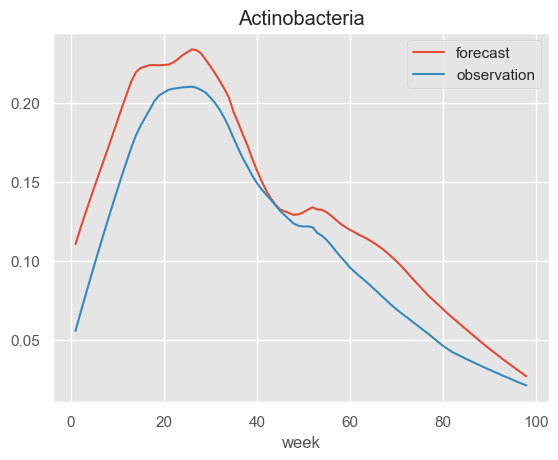

In [13]:
DF_pop = DF.groupby(["variable", "week"]).mean(numeric_only=True).reset_index()
DF_data = data.groupby(["variable", "week"]).mean(numeric_only=True).reset_index()

DF_pop_smooth = qsmooth(
    DF_pop,
    index="week",
    columns="variable",
    normalize=False,
    alpha=0.99,
    interpolate=False,
    lowess_fraction=0.3,
)

# DF_data_smooth
DF_data_smooth = qsmooth(
    DF_data,
    index="week",
    columns="variable",
    normalize=False,
    alpha=0.99,
    interpolate=False,
    lowess_fraction=0.3,
)


ax = DF_pop_smooth.Actinobacteria.plot(label="forecast")
DF_data_smooth.Actinobacteria.plot(ax=ax, label="observation")
ax.set_title("Actinobacteria")
ax.legend()

In [14]:
data.subject_id.value_counts().index.values

array(['1', '41', '38', '20', '27', '43', '33', '32', '31', '42', '7',
       '24', '25', '37', '12', '44', '16', '5', '30', '35', '10', '46',
       '14', '18', '11', '9', '34', '8', '2', '49', '57', '45', '22',
       '36', '4', '56', '21', '53', '47', '55', '17', '52', '23', '50'],
      dtype=object)

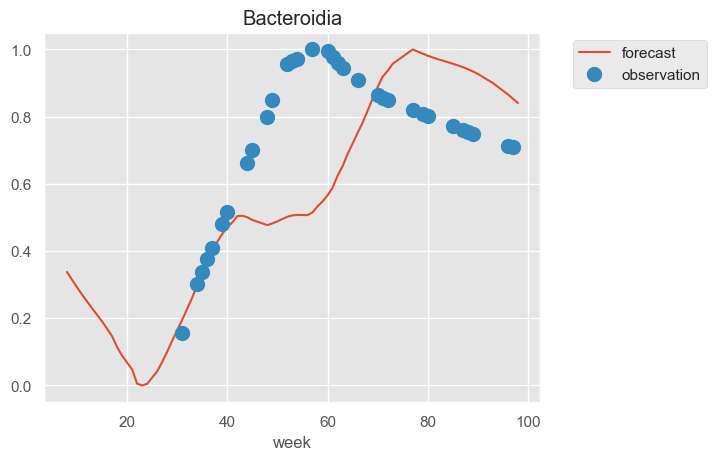

In [15]:
SID = "21"
DF_pop = (
    DF[DF.subject_id == SID]
    .groupby(["variable", "week"])
    .mean(numeric_only=True)
    .reset_index()
)
DF_data = (
    data[DF.subject_id == SID]
    .groupby(["variable", "week"])
    .mean(numeric_only=True)
    .reset_index()
)
DF_pop_smooth = qsmooth(
    DF_pop,
    index="week",
    columns="variable",
    normalize=True,
    alpha=0.99,
    interpolate=False,
    lowess_fraction=0.4,
)

# DF_data_smooth
DF_data_smooth = qsmooth(
    DF_data,
    index="week",
    columns="variable",
    normalize=True,
    alpha=0.99,
    interpolate=False,
    lowess_fraction=0.6,
)

var = "Bacteroidia"
ax = DF_pop_smooth[var].plot(label="forecast")
DF_data_smooth[var].plot(ax=ax, style="o", ms=10, label="observation")
ax.set_title("Bacteroidia")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

## Forecast data for a new patient

Read in new data, quantize, and forecast:

,week,variable,value
0,29,Bacilli,0.868607
1,29,Clostridia,0.935282
2,29,Actinobacteria,0.147838
3,29,Gammaproteobacteria,0.283633
4,29,Bacteroidia,0.932206
5,29,Negativicutes,0.877186
6,29,Coriobacteriia,0.198159
7,29,Verrucomicrobiae,0.250012
8,29,Desulfovibrionia,0.367589
9,29,Fusobacteriia,0.982425


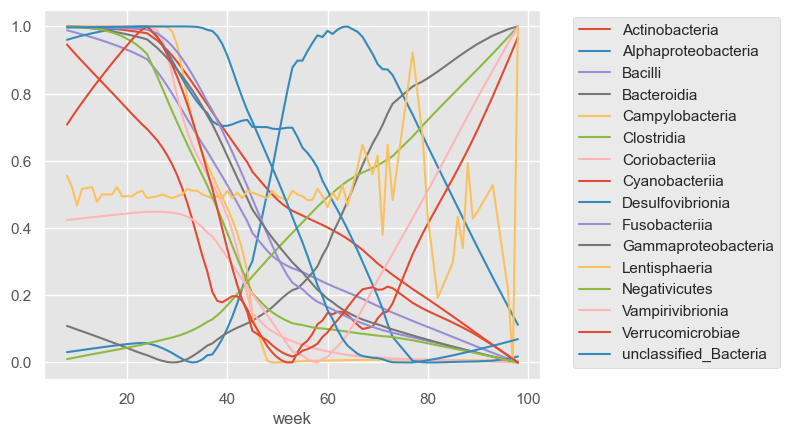

In [16]:
new_subject = pd.DataFrame(
    {
        "week": [SW] * len(BIOMES),
        "variable": BIOMES,
        "value": np.random.rand(len(BIOMES)),
    }
)

new_subject.to_csv("example_data/single_patient_dummy/new_subject.csv", index=None)
new_subject = pd.read_csv("example_data/single_patient_dummy/new_subject.csv")
display(new_subject)

new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id=12345)
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster.forecast_data(
    new_subject_matrix, start_week=29, subject_id=[12345]
)

df_ = qsmooth(
    new_subject_forecasted.drop("subject_id", axis=1),
    index="week",
    columns="variable",
    interpolate=False,
    alpha=0.5,
    lowess_fraction=0.5,
    normalize=True,
)

ax = df_.plot()
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

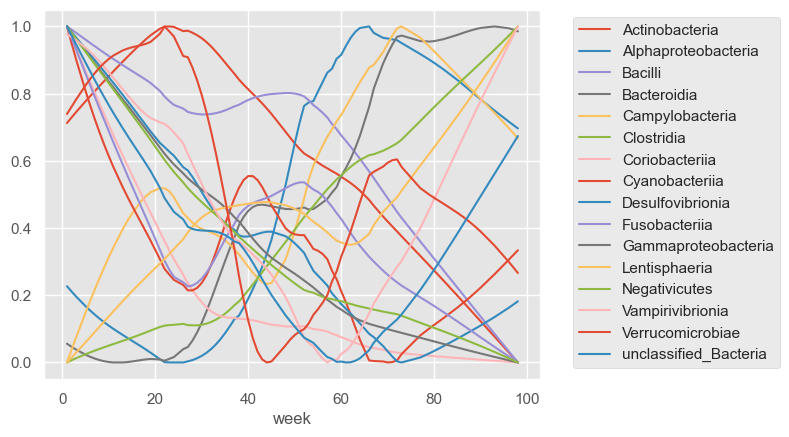

In [17]:
new_subject = pd.read_csv("example_data/single_patient_dummy/new_subject_001.csv")
# display(new_subject)

new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id="1011")
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster.forecast_data(
    new_subject_matrix, start_week=1, subject_id=["1011"]
)
df_ = qsmooth(
    new_subject_forecasted.drop("subject_id", axis=1),
    index="week",
    columns="variable",
    interpolate=False,
    alpha=0.5,
    lowess_fraction=0.5,
    normalize=True,
)

ax = df_.plot()
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

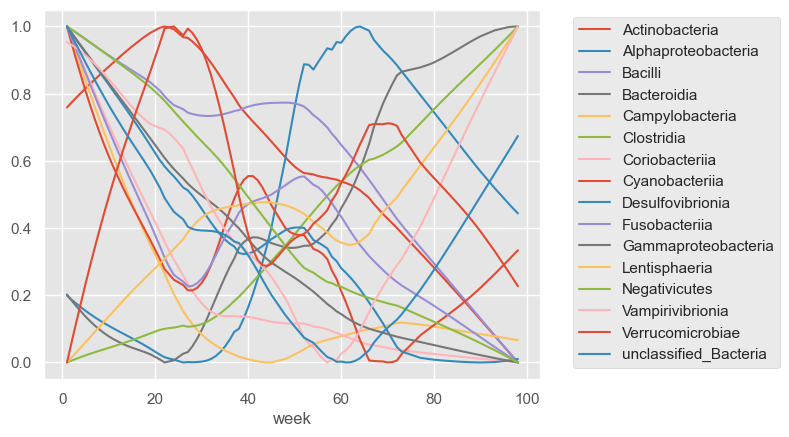

In [18]:
new_subject = pd.read_csv("example_data/single_patient_dummy/new_subject_002.csv")
# display(new_subject)

new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id="1012")
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster.forecast_data(
    new_subject_matrix, start_week=1, subject_id=["1012"]
)
df_ = qsmooth(
    new_subject_forecasted.drop("subject_id", axis=1),
    index="week",
    columns="variable",
    interpolate=False,
    alpha=0.5,
    lowess_fraction=0.5,
    normalize=True,
)

ax = df_.plot()
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

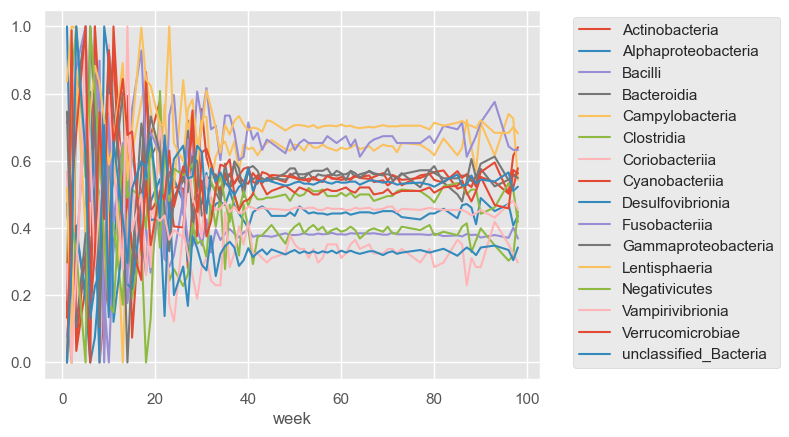

In [19]:
new_subject = (
    data[(data.subject_id == "10") & (data.week < 32)]
    .drop("sample_id", axis=1)
    .reset_index(drop=True)
)

new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id="1013")
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster.forecast_data(
    new_subject_matrix, start_week=1, end_week=20, subject_id=["1013"]
)
df_ = qsmooth(
    new_subject_forecasted.drop("subject_id", axis=1),
    index="week",
    columns="variable",
    interpolate=False,
    alpha=0.5,
    lowess_fraction=0.6,
    normalize=True,
)

ax = df_.plot()
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")